# 13.4 Nonlinear Autoencoder Using Neural Networks 

In [520]:
import numpy as np

In [521]:
from matplotlib import gridspec

In [522]:
datapath = '/users/jazz13/Desktop/GitHub_Files/435-deep-learning/'

In [523]:
#datapath = '/home/venkat/Desktop/GitHub_Files/435-deep-learning/'

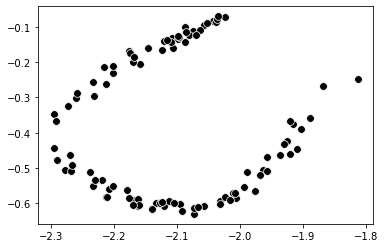

In [524]:
import matplotlib.pyplot as plt

# import data
X = np.loadtxt(datapath + 'universal_autoencoder_samples.csv', delimiter=',')

plt.scatter(X[0,:], X[1,:], c = 'k', s = 60, linewidth = 0.75, edgecolor = 'w')
plt.show()

In [525]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [526]:
import history_plotters
import multilayer_perceptron_batch_normalized
import multilayer_perceptron
import normalizers
import cost_functions
import un_cost_functions
import un_optimizers

In [527]:
import autograd.numpy as np
 
class Setup:
    def __init__(self,X,**kwargs):
        # link in data
        self.x = X
        
        # make containers for all histories
        self.weight_histories = []
        self.train_cost_histories = []
        self.train_accuracy_histories = []
        self.val_cost_histories = []
        self.val_accuracy_histories = []
        self.train_costs = []
        self.train_counts = []
        self.val_costs = []
        self.val_counts = []

        
        
    #### define preprocessing steps ####
    def preprocessing_steps(self,**kwargs):        
        ### produce / use data normalizer ###
        normalizer_name = 'standard'
        if 'normalizer_name' in kwargs:
            normalizer_name = kwargs['normalizer_name']
        self.normalizer_name = normalizer_name

        # produce normalizer / inverse normalizer
        s = normalizers.Setup(self.x,normalizer_name)
        self.normalizer = s.normalizer
        self.inverse_normalizer = s.inverse_normalizer
        
        # normalize input 
        self.x = self.normalizer(self.x)
        
    #### split data into training and validation sets ####
    def make_train_val_split(self,train_portion):
        # translate desired training portion into exact indecies
        self.train_portion = train_portion
        r = np.random.permutation(self.x.shape[1])
        train_num = int(np.round(train_portion*len(r)))
        self.train_inds = r[:train_num]
        self.val_inds = r[train_num:]
        
        # define training and testing sets
        self.x_train = self.x[:,self.train_inds]
        self.x_val = self.x[:,self.val_inds]
        
    #### define encoder ####
    def choose_encoder(self,**kwargs):         
        feature_name = 'multilayer_perceptron'
        if 'name' in kwargs:
            feature_name = kwargs['feature_name']
        
        transformer = 0
        if feature_name == 'multilayer_perceptron':
            transformer = multilayer_perceptron.Setup(**kwargs)
        elif feature_name == 'multilayer_perceptron_batch_normalized':
            transformer = multilayer_perceptron_batch_normalized.Setup(**kwargs)
            
        self.feature_transforms = transformer.feature_transforms
        self.initializer_1 = transformer.initializer
     
    # form decoder
    def choose_decoder(self,**kwargs):         
        feature_name = 'multilayer_perceptron'
        if 'name' in kwargs:
            feature_name = kwargs['feature_name']
           
        transformer = 0
        if feature_name == 'multilayer_perceptron':
            transformer = multilayer_perceptron.Setup(**kwargs)
        elif feature_name == 'multilayer_perceptron_batch_normalized':
            transformer = multilayer_perceptron_batch_normalized.Setup(**kwargs)
        
        self.feature_transforms_2 = transformer.feature_transforms
        self.initializer_2 = transformer.initializer
     
    def choose_cost(self,name,**kwargs):
        # pick cost based on user input
        self.cost_object = un_cost_functions.Setup(name,**kwargs)
                
        ### with feature transformation constructed, pass on to cost function ###
        self.cost_object.define_encoder_decoder(self.feature_transforms,self.feature_transforms_2)
        self.cost = self.cost_object.cost
        self.cost_name = name
        self.encoder = self.cost_object.encoder
        self.decoder = self.cost_object.decoder
    
     #### run optimization ####
    def fit(self,**kwargs):
        # basic parameters for gradient descent run (default algorithm)
        max_its = 500; alpha_choice = 10**(-1);
        self.w_init_1 = self.initializer_1()
        self.w_init_2 = self.initializer_2()
        self.w_init = [self.w_init_1,self.w_init_2]
        
        # set parameters by hand
        if 'max_its' in kwargs:
            self.max_its = kwargs['max_its']
        if 'alpha_choice' in kwargs:
            self.alpha_choice = kwargs['alpha_choice']
        if 'w' in kwargs:
            self.w_init = kwargs['w']

        # batch size for gradient descent?
        self.train_num = np.shape(self.x_train)[1]
        self.val_num = np.shape(self.x_val)[1]
        self.batch_size = np.shape(self.x_train)[1]
        if 'batch_size' in kwargs:
            self.batch_size = min(kwargs['batch_size'],self.batch_size)
        
        # verbose or not
        verbose = True
        if 'verbose' in kwargs:
            verbose = kwargs['verbose']
        
        # run gradient descent
        weight_history,train_cost_history,val_cost_history = un_optimizers.gradient_descent(self.cost,self.w_init,self.x_train,self.x_val,self.alpha_choice,self.max_its,self.batch_size,verbose=verbose)
        
        # store all new histories
        self.weight_histories.append(weight_history)
        self.train_cost_histories.append(train_cost_history)
        self.val_cost_histories.append(val_cost_history)
        
    def show_histories(self,**kwargs):
        start = 0
        if 'start' in kwargs:
            start = kwargs['start']
        if self.train_portion == 1:
            self.val_cost_histories = [[] for s in range(len(self.val_cost_histories))]
            self.val_accuracy_histories = [[] for s in range(len(self.val_accuracy_histories))]
        history_plotters.Setup(self.train_cost_histories,self.train_accuracy_histories,self.val_cost_histories,self.val_accuracy_histories,start)
        
    

In [528]:
mylib = Setup(X)

In [529]:
mylib.preprocessing_steps(normalizer = 'standard')

In [530]:
# split into training and validation sets
mylib.make_train_val_split(train_portion = 1)

In [531]:
# choose features
mylib.choose_encoder(layer_sizes = [2,10,10,1],scale = 0.2)
mylib.choose_decoder(layer_sizes = [1,10,10,2],scale = 0.2)

In [532]:
mylib.choose_cost(name = 'autoencoder')

In [533]:
mylib.fit(max_its = 3000,alpha_choice = 10**(-1),verbose = False)

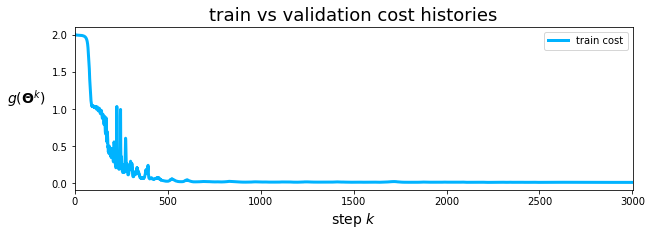

In [534]:
mylib.show_histories()

In [535]:
import autoencoder_demos

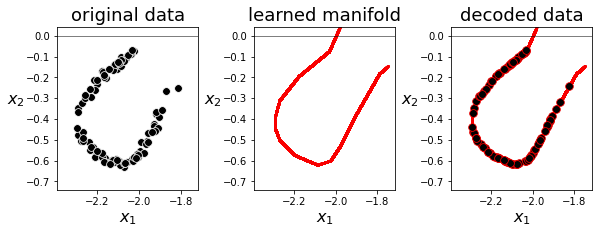

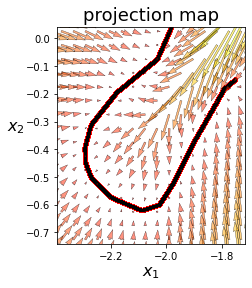

In [537]:
autoencoder_demos.show_encode_decode(X,mylib,projmap = True,scale = 5)

# 13.8 Batch Normalization 

In [538]:
import sklearn
sklearn.__version__

'1.0.2'

In [539]:
conda update scikit-learn

python(69312) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Solving environment: | 

Updating scikit-learn is constricted by 

anaconda -> requires scikit-learn==1.0.2=py39hae1ba45_1

If you are sure you want an update of your package either try `conda update --all` or install a specific version of the package you want using `conda install <pkg>=<version>`

done


==> WARNING: A newer version of conda exists. <==
  current version: 4.13.0
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [540]:
import super_cost_functions
import history_plotters
import multilayer_perceptron_batch_normalized
import multilayer_perceptron
import normalizers
import cost_functions
import super_optimizers

In [541]:
# get MNIST data from online repository
from sklearn.datasets import fetch_openml
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# convert string labels to integers
y = np.array([int(v) for v in y])[:,np.newaxis]

print(np.shape(x))
print(np.shape(y))

(70000, 784)
(70000, 1)


In [542]:
x1 = np.transpose(x)
y1 = np.transpose(y)

In [553]:
x_sample, x_test = x[:50000],x[50000:]
y_sample, y_test=y[:50000],y[50000:]

splitting to training and validation, randomly selecting the training set. 

In [554]:
shuffled = np.random.permutation(50000)
x_sample = x_sample.iloc[shuffled] 
y_sample = y_sample[shuffled]

In [555]:
print(x_sample.shape)
print(y_sample.shape)

(50000, 784)
(50000, 1)


In [556]:
class Setup2:
    def __init__(self,x,y,**kwargs):
        # link in data
        self.x = x
        self.y = y
        
        # make containers for all histories
        self.weight_histories = []
        self.train_cost_histories = []
        self.train_accuracy_histories = []
        self.val_cost_histories = []
        self.val_accuracy_histories = []
        self.train_costs = []
        self.train_counts = []
        self.val_costs = []
        self.val_counts = []
        
        
    #### define preprocessing steps ####
    def preprocessing_steps(self,**kwargs):        
        ### produce / use data normalizer ###
        normalizer_name = 'standard'
        if 'normalizer_name' in kwargs:
            normalizer_name = kwargs['normalizer_name']
        self.normalizer_name = normalizer_name

        # produce normalizer / inverse normalizer
        s = normalizers.Setup(self.x,normalizer_name)
        self.normalizer = s.normalizer
        self.inverse_normalizer = s.inverse_normalizer
        
        # normalize input 
        self.x = self.normalizer(self.x)
       
    #### split data into training and validation sets ####
    def make_train_val_split(self,train_portion):
        # translate desired training portion into exact indecies
        self.train_portion = train_portion
        r = np.random.permutation(self.x.shape[1])
        train_num = int(np.round(train_portion*len(r)))
        self.train_inds = r[:train_num]
        self.val_inds = r[train_num:]
        
        # define training and testing sets
        self.x_train = self.x[:,self.train_inds]
        self.x_val = self.x[:,self.val_inds]

        self.y_train = self.y[:,self.train_inds]
        self.y_val = self.y[:,self.val_inds]
     
    #### define cost function ####
    def choose_cost(self,name,**kwargs):
        # create training and testing cost functions
        self.cost_object = super_cost_functions.Setup(name,**kwargs)

        # if the cost function is a two-class classifier, build a counter too
        if name == 'softmax' or name == 'perceptron':
            self.count_object = super_cost_functions.Setup('twoclass_counter',**kwargs)
                        
        if name == 'multiclass_softmax' or name == 'multiclass_perceptron':
            self.count_object = super_cost_functions.Setup('multiclass_counter',**kwargs)
  
        self.cost_name = name
    
    #### define feature transformation ####
    def choose_features(self,**kwargs): 
        ### select from pre-made feature transforms ###
        layer_sizes = [1]
        if 'layer_sizes' in kwargs:
            layer_sizes = kwargs['layer_sizes']
        
        # add input and output layer sizes
        input_size = self.x.shape[0]
        layer_sizes.insert(0, input_size)
      
        # add output size
        if self.cost_name == 'least_squares' or self.cost_name == 'least_absolute_deviations':
            layer_sizes.append(self.y.shape[0])
        else:
            num_labels = len(np.unique(self.y))
            if num_labels == 2:
                layer_sizes.append(1)
            else:
                layer_sizes.append(num_labels)
        
        # multilayer perceptron #
        feature_name = 'multilayer_perceptron'
        if 'name' in kwargs:
            feature_name = kwargs['feature_name']
           
        if feature_name == 'multilayer_perceptron':
            transformer = multilayer_perceptron.Setup(**kwargs)
            self.feature_transforms = transformer.feature_transforms
            self.multilayer_initializer = transformer.initializer
            self.layer_sizes = transformer.layer_sizes
            
        if feature_name == 'multilayer_perceptron_batch_normalized':
            transformer = multilayer_perceptron_batch_normalized.Setup(**kwargs)
            self.feature_transforms = transformer.feature_transforms
            self.multilayer_initializer = transformer.initializer
            self.layer_sizes = transformer.layer_sizes
            
        self.feature_name = feature_name
        
        ### with feature transformation constructed, pass on to cost function ###
        self.cost_object.define_feature_transform(self.feature_transforms)
        self.cost = self.cost_object.cost
        self.model = self.cost_object.model
        
        # if classification performed, inject feature transforms into counter as well
        if self.cost_name == 'softmax' or self.cost_name == 'perceptron' or self.cost_name == 'multiclass_softmax' or self.cost_name == 'multiclass_perceptron':
            self.count_object.define_feature_transform(self.feature_transforms)
            self.counter = self.count_object.cost
            
    #### run optimization ####
    def fit(self,**kwargs):
        # basic parameters for gradient descent run (default algorithm)
        max_its = 500; alpha_choice = 10**(-1);
        
        # set parameters by hand
        if 'max_its' in kwargs:
            self.max_its = kwargs['max_its']
        if 'alpha_choice' in kwargs:
            self.alpha_choice = kwargs['alpha_choice']
        
        # set initialization
        self.w_init = self.multilayer_initializer()
        
        # batch size for gradient descent?
        self.train_num = np.size(self.y_train)
        self.val_num = np.size(self.y_val)
        self.batch_size = np.size(self.y_train)
        if 'batch_size' in kwargs:
            self.batch_size = min(kwargs['batch_size'],self.batch_size)
        
        # verbose or not
        verbose = True
        if 'verbose' in kwargs:
            verbose = kwargs['verbose']

        # optimize
        weight_history = []
        cost_history = []
        
        # run gradient descent
        weight_history,train_cost_history,val_cost_history = super_optimizers.gradient_descent(self.cost,self.w_init,self.x_train,self.y_train,self.x_val,self.y_val,self.alpha_choice,self.max_its,self.batch_size,verbose=verbose)
                                                                                         
        # store all new histories
        self.weight_histories.append(weight_history)
        self.train_cost_histories.append(train_cost_history)
        self.val_cost_histories.append(val_cost_history)

        # if classification produce count history
        if self.cost_name == 'softmax' or self.cost_name == 'perceptron' or self.cost_name == 'multiclass_softmax' or self.cost_name == 'multiclass_perceptron':
            train_accuracy_history = [1 - self.counter(v,self.x_train,self.y_train)/float(self.y_train.size) for v in weight_history]
            val_accuracy_history = [1 - self.counter(v,self.x_val,self.y_val)/float(self.y_val.size) for v in weight_history]

            # store count history
            self.train_accuracy_histories.append(train_accuracy_history)
            self.val_accuracy_histories.append(val_accuracy_history)
 
    #### plot histories ###
    def show_histories(self,**kwargs):
        start = 0
        if 'start' in kwargs:
            start = kwargs['start']
        if self.train_portion == 1:
            self.val_cost_histories = [[] for s in range(len(self.val_cost_histories))]
            self.val_accuracy_histories = [[] for s in range(len(self.val_accuracy_histories))]
        history_plotters.Setup(self.train_cost_histories,self.train_accuracy_histories,self.val_cost_histories,self.val_accuracy_histories,start)
        
    #### for batch normalized multilayer architecture only - set normalizers to desired settings ####
    def fix_normalizers(self,w):
        ### re-set feature transformation ###        
        # fix normalization at each layer by passing data and specific weight through network
        self.feature_transforms(self.x,w);
        
        # re-assign feature transformation based on these settings
        self.testing_feature_transforms = self.transformer.testing_feature_transforms
        
        ### re-assign cost function (and counter) based on fixed architecture ###
        funcs = cost_functions.Setup(self.cost_name,self.x,self.y,self.testing_feature_transforms)
        self.model = funcs.model

In [580]:
import super_setup

In [581]:
mylib2 = super_setup.Setup(x_sample,y_sample)

In [582]:
mylib2.preprocessing_steps(normalizer = 'standard')

In [583]:
mylib2.make_train_val_split(train_portion = 1)

InvalidIndexError: (slice(None, None, None), array([469, 531, 229, 350, 564, 684, 464, 442, 261,  24, 354, 260, 105,
       736, 420, 234, 465, 383, 232,  85,   5, 214, 668, 720, 765, 386,
       268, 633, 431, 300, 425, 599, 181, 576, 435, 473, 215, 253, 318,
       135, 394, 481, 589, 429, 334, 505, 486, 267, 500, 667,   6,  87,
       438, 755, 358,  61, 410,  95, 285, 196, 462, 767, 397, 445, 518,
        65, 244, 502,  81, 372,  10, 550, 359, 128, 758, 570, 451, 414,
       769, 661, 374,  26, 665, 513, 492, 310, 272, 539, 400, 713, 349,
       588, 346, 264, 321, 145, 620, 311, 391, 526, 453, 644, 102, 233,
       412, 273, 193, 711, 117, 362,  59,  34,  13, 460, 730, 634, 293,
        51, 162, 466, 585, 508, 389, 648, 692,   9, 344, 316, 148, 369,
       471, 324, 275, 141, 426,   2, 454, 175, 441, 696, 754, 507, 338,
       738, 123, 560, 291,  71, 559,  21, 618, 527, 118, 495, 119, 554,
       160, 549, 304, 132,  36, 422, 732, 525,  14, 510, 107, 582, 673,
       238, 401,  83, 265, 199, 330, 301, 737, 299, 328, 468, 133, 574,
       491, 756, 187, 726, 725, 694, 168, 750, 583, 664, 379, 688, 129,
       274, 224,  98, 161,  64, 703,  57, 704,  30, 130, 337, 623,  19,
       543, 169, 540, 751, 432,  88, 403, 630, 207, 327, 191, 649, 669,
       523, 289, 343, 749,  75, 779, 760, 256, 573, 222, 146, 562, 279,
       547, 496, 635, 555, 131, 485, 287, 714,  74,  53, 602,  39,  22,
       748, 613, 458, 551,  99, 143, 332, 590, 521, 437, 174, 566, 516,
       357, 155, 104, 619, 638, 467, 100,  56, 452, 381, 257, 434, 771,
       625, 173, 655, 249, 239,   4, 203, 712,  16,  97, 345,  33, 182,
        76, 651,  45,  62, 709,  48, 326, 561, 163, 308, 387, 248, 614,
       627,  86, 483, 517, 715, 757, 753, 245, 641, 368, 341, 190, 329,
       242, 276, 360, 653, 192, 681,  31, 290, 231, 385, 415, 729,  89,
       735, 535, 269, 776,  84,  80, 536, 474, 125, 364, 695, 298,  20,
       195, 246, 739, 306, 743, 448, 584, 171, 382, 419, 493,   8, 591,
        79, 281, 674, 774, 575, 235, 206, 722, 546, 416, 142, 501,  63,
       361, 617,  93, 522, 565, 645, 719, 721, 363, 676, 172, 687, 380,
       377, 157, 677, 459, 761,  28, 201, 134, 252, 666, 611, 140, 430,
       529, 149, 710, 303, 266, 553,  27,  69, 775, 378, 558, 724, 418,
       514,  91, 254, 637, 717, 506, 417, 433, 689, 691, 541, 263,  66,
       600, 159, 323, 587,  52, 646, 700,  11, 367, 658, 405, 482, 731,
       671, 164, 208, 194, 702, 701, 106, 288, 479, 777, 250, 137, 772,
       783,  12, 115, 241, 440, 376, 251, 356, 572, 621, 456, 185, 503,
       631, 497, 728, 487, 247, 533, 331,  42, 511,  72, 686, 563,  18,
         0,  46, 612, 220, 136, 413, 461, 716, 718, 399, 484,  23, 325,
       366, 408, 578, 608, 639, 616, 165, 763, 556, 597, 315, 605,  82,
       138, 342, 150, 577, 654,  68, 449, 305, 370, 601, 183, 524, 225,
       271, 494, 628, 532, 286, 373, 424, 504, 200, 212, 421, 340, 259,
        44, 659, 388,  67, 443, 371, 230, 176, 211,  77, 544, 675, 734,
       351, 209, 446,  38, 764, 384, 592, 314, 406, 660, 699, 683, 744,
       103, 604, 470, 698, 586, 610, 216, 568, 177, 670, 404, 243, 221,
       213, 427, 109, 114, 690, 579, 685,  35, 151, 348, 678, 530, 571,
       255, 110, 121, 205, 154, 626, 428, 284, 295,  37, 705, 552, 217,
       228,  43, 606, 706, 262, 642, 111, 258, 278, 450, 762, 280,   3,
       607, 393,  47,  55, 476, 569, 534, 598, 594, 746, 499, 112, 270,
       650,  96, 439, 490, 657, 409, 320, 768,  49, 636,  29, 179, 455,
       593, 392, 742,  25, 498, 528, 520, 297, 352,  50,  40, 647, 204,
       302, 353, 782, 632, 237, 317, 515, 580, 463, 609, 557, 108, 198,
       693, 663, 113, 294, 355,  41, 662, 640, 629, 759, 127, 186, 733,
       447, 313, 398, 101, 227, 747, 336, 402, 680, 395, 436, 423, 365,
       477,  15, 153,  73, 727, 202, 679, 166, 457, 741, 309,  78, 167,
       488,  70, 509, 156, 218, 603,   7, 122,  94, 682,  92, 740, 778,
       307, 567, 781,  32, 223,  90, 656, 296, 147, 652, 723, 319, 210,
       411, 475, 512, 596, 766, 189, 697,   1, 643,  58, 124, 624, 396,
       277, 519, 752, 375, 144, 347, 770, 548,  17, 152, 672, 322, 292,
       444, 708, 184, 745, 595, 197, 489, 622,  60, 542, 236, 188, 407,
       538, 219, 170, 390, 335, 339, 120, 139, 226, 158, 478, 537, 472,
       480, 240,  54, 178, 283, 333, 126, 180, 707, 615, 116, 282, 773,
       545, 581, 780, 312]))

In [584]:
# choose cost
mylib2.choose_cost(name = 'multiclass_softmax')

In [585]:
# choose dimensions of fully connected multilayer perceptron layers
layer_sizes = [10,10,10,10]
mylib2.choose_features(feature_name = 'multilayer_perceptron',layer_sizes = layer_sizes, activation = 'relu',scale = 0.1)

In [586]:
mylib2.fit(max_its = 10,alpha_choice = 10**(-2),verbose = False,batch_size = 200)

AttributeError: 'Setup' object has no attribute 'y_train'

In [587]:
# component-wise normalized version
mylib2.choose_features(feature_name = 'multilayer_perceptron_batch_normalized',layer_sizes = layer_sizes,activation = 'relu',scale = 0.1)
mylib2.fit(max_its = 10,alpha_choice = 10**(-1),verbose = False,w_init = mylib.w_init,batch_size = 200)

AttributeError: 'Setup' object has no attribute 'y_train'

In [ ]:
 # plot cost function history
labels = ['regular','batch-normalized']
mylib2.show_multirun_histories(start = 0,labels = labels)

# 13.9 Early Stopping Cross-Validation

In [456]:
# load in dataset
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname, delimiter = ',')
x = data[:-1,:]
y = data[-1:,:]

print(np.shape(x))
print(np.shape(y))


(20, 2)
(1, 2)


In [457]:
import polys
import cost_functions3
import optimizers

In [472]:
class Setup3:
    def __init__(self,x,y,**kwargs):
        # link in data
        self.x = x
        self.y = y
        
        # make containers for all histories
        self.weight_histories = []
        self.train_cost_histories = []
        self.train_count_histories = []
        self.valid_cost_histories = []
        self.valid_count_histories = []
        
    #### define feature transformation ####
    def choose_features(self,name,**kwargs): 
        ### select from pre-made feature transforms ###
        # multilayer perceptron #
        if name == 'multilayer_perceptron':
            self.transformer = multilayer_perceptron.Setup(**kwargs)
            self.feature_transforms = self.transformer.feature_transforms
            self.initializer = self.transformer.initializer
            self.layer_sizes = self.transformer.layer_sizes
            
        if name == 'multilayer_perceptron_batch_normalized':
            self.transformer = multilayer_perceptron_batch_normalized.Setup(**kwargs)
            self.feature_transforms = self.transformer.feature_transforms
            self.initializer = self.transformer.initializer
            self.layer_sizes = self.transformer.layer_sizes
            
        # polynomials #
        if name == 'polys':
            self.transformer = polys.Setup(self.x,self.y,**kwargs)
            self.feature_transforms = self.transformer.feature_transforms
            self.initializer = self.transformer.initializer
            self.degs = self.transformer.D            
            
        self.feature_name = name

    #### define normalizer ####
    def choose_normalizer(self,name):
        # produce normalizer / inverse normalizer
        s = normalizers.Setup(self.x,name)
        self.normalizer = s.normalizer
        self.inverse_normalizer = s.inverse_normalizer
        
        # normalize input 
        self.x = self.normalizer(self.x)
        self.normalizer_name = name
       
    #### split data into training and validation sets ####
    def make_train_valid_split(self,train_portion):
        # translate desired training portion into exact indecies
        r = np.random.permutation(self.x.shape[1])
        train_num = int(np.round(train_portion*len(r)))
        self.train_inds = r[:train_num]
        self.valid_inds = r[train_num:]
        
        # define training and validation sets
        self.x_train = self.x[:,self.train_inds]
        self.x_valid = self.x[:,self.valid_inds]
        
        self.y_train = self.y[:,self.train_inds]
        self.y_valid = self.y[:,self.valid_inds]
     
    #### define cost function ####
    def choose_cost(self,name,**kwargs):
        # create cost on entire dataset
        funcs = cost_functions3.Setup(name,self.x,self.y,self.feature_transforms,**kwargs)
        self.full_cost = funcs.cost
        self.full_model = funcs.model

        # create training and validation cost functions
        funcs = cost_functions3.Setup(name,self.x_train,self.y_train,self.feature_transforms,**kwargs)
        self.cost = funcs.cost
        self.model = funcs.model
        
        funcs = cost_functions3.Setup(name,self.x_valid,self.y_valid,self.feature_transforms,**kwargs)
        self.valid_cost = funcs.cost
        self.valid_model = funcs.model

        # if the cost function is a two-class classifier, build a counter too
        if name == 'softmax' or name == 'perceptron':
            funcs = cost_functions3.Setup('twoclass_counter',self.x_train,self.y_train,self.feature_transforms,**kwargs)
            self.counter = funcs.cost
            
            funcs = cost_functions3.Setup('twoclass_counter',self.x_valid,self.y_valid,self.feature_transforms,**kwargs)
            self.valid_counter = funcs.cost
            
        if name == 'multiclass_softmax' or name == 'multiclass_perceptron':
            funcs = cost_functions3.Setup('multiclass_counter',self.x_train,self.y_train,self.feature_transforms,**kwargs)
            self.counter = funcs.cost
            
            funcs = cost_functions3.Setup('multiclass_counter',self.x_valid,self.y_valid,self.feature_transforms,**kwargs)
            self.valid_counter = funcs.cost
            
        self.cost_name = name
            
    #### run optimization ####
    def fit(self,**kwargs):
        # basic parameters for gradient descent run (default algorithm)
        max_its = 500; alpha_choice = 10**(-1);
        self.w_init = self.initializer()
        optimizer = 'gradient_descent'
        epsilon = 10**(-10)
        
        # set parameters by hand
        if 'max_its' in kwargs:
            self.max_its = kwargs['max_its']
        if 'alpha_choice' in kwargs:
            self.alpha_choice = kwargs['alpha_choice']
        if 'optimizer' in kwargs:
            optimizer = kwargs['optimizer']
        if 'epsilon' in kwargs:
            epsilon = kwargs['epsilon']
        if 'init' in kwargs:
            print ('here')
            self.w_init = kwargs['init']
            
        # batch size for gradient descent?
        self.num_pts = np.size(self.y_train)
        self.batch_size = np.size(self.y_train)
        if 'batch_size' in kwargs:
            self.batch_size = kwargs['batch_size']

        # optimize
        weight_history = []
        
        # run gradient descent
        if optimizer == 'gradient_descent':
            weight_history = optimizers.gradient_descent(self.cost,self.alpha_choice,self.max_its,self.w_init,self.num_pts,self.batch_size)
        
        if optimizer == 'RMSprop':
            weight_history = optimizers.RMSprop(self.cost,self.alpha_choice,self.max_its,self.w_init,self.num_pts,self.batch_size)
 
        # run gradient descent
        if optimizer == 'newtons_method':
            epsilon = 10**(-10)
            if 'epsilon' in kwargs:
                epsilon = kwargs['epsilon']
            weight_history = optimizers.newtons_method(self.cost,epsilon,self.max_its,self.w_init,self.num_pts,self.batch_size)
        

        # compute training history
        train_cost_history = [self.cost(v,np.arange(np.size(self.y_train))) for v in weight_history]
        
        # store all new histories
        self.weight_histories.append(weight_history)
        self.train_cost_histories.append(train_cost_history)
        
        # compute validation history
        if len(self.valid_inds) > 0:
            valid_cost_history = [self.valid_cost(v,np.arange(np.size(self.y_valid))) for v in weight_history]
            self.valid_cost_histories.append(valid_cost_history)
        
        # if classification produce count history
        if self.cost_name == 'softmax' or self.cost_name == 'perceptron' or self.cost_name == 'multiclass_softmax' or self.cost_name == 'multiclass_perceptron':
            train_count_history = [self.counter(v) for v in weight_history]
            self.train_count_histories.append(train_count_history)
            
            if len(self.valid_inds) > 0:
                valid_count_history = [self.valid_counter(v) for v in weight_history]
                self.valid_count_histories.append(valid_count_history)
 
    #### plot histories ###
    def show_histories(self,**kwargs):
        start = 0
        if 'start' in kwargs:
            start = kwargs['start']
        history_plotters.Setup(self.train_cost_histories,self.train_count_histories,self.valid_cost_histories,self.valid_count_histories,start)
        
    #### for batch normalized multilayer architecture only - set normalizers to desired settings ####
    def fix_normalizers(self,w):
        ### re-set feature transformation ###        
        # fix normalization at each layer by passing data and specific weight through network
        self.feature_transforms(self.x,w);
        
        # re-assign feature transformation based on these settings
        self.validation_feature_transforms = self.transformer.validation_feature_transforms
        
        ### re-assign cost function (and counter) based on fixed architecture ###
        funcs = cost_functions.Setup(self.cost_name,self.x,self.y,self.validation_feature_transforms)
        self.model = funcs.model

In [473]:
mylib3 = Setup3(x,y)

In [474]:
layer_sizes = [1,10,10,10,1]

In [475]:
mylib3.choose_features(name = 'multilayer_perceptron',layer_sizes = layer_sizes,activation = 'tanh')

In [476]:
mylib3.choose_normalizer(name = 'standard')

In [477]:
mylib3.make_train_valid_split(train_portion = 0.66)

In [478]:
mylib3.choose_cost(name = 'least_squares')

In [136]:
mylib3.fit(max_its = 10000,alpha_choice = 10**(-1))

ValueError: shapes (1,20) and (1,10) not aligned: 20 (dim 1) != 1 (dim 0)

# 13.10 Hand Written Digit Recognition Using Neural Networks 

In [183]:
from sklearn.model_selection import train_test_split

In [279]:
# get MNIST data from online repository
from sklearn.datasets import fetch_openml
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)



In [280]:
# convert string labels to integers
y = np.array([int(v) for v in y])[:,np.newaxis]

print(np.shape(x))
print(np.shape(y))

(70000, 784)
(70000, 1)


In [285]:
x1 = x.T
y1  = y.T

In [286]:
# standard normalization function - with nan checker / filler in-er 

def standard_normalizer(x1):
    # compute the mean and standard deviation of the input
    x_means = np.nanmean(x1,axis = 1)[:,np.newaxis]
    x_stds = np.nanstd(x1,axis = 1)[:,np.newaxis]
    
    # create standard normalizer function
   
    normalizer = lambda data: (data - x_means)/x_stds # create inverse standard normalizer
    inverse_normalizer = lambda data: data*x_stds + x_means # return normalizer
    
    return normalizer,inverse_normalizer 

normalizer,inverse_normalizer = standard_normalizer(x1.T)
x1 = normalizer(x1.T).T


In [331]:
x_sample, x_test = x[:50000],x[50000:]
y_sample, y_test=y[:50000],y[50000:]

In [332]:
shuffled = np.random.permutation(50000)
x_sample = x_sample.iloc[shuffled] 
y_sample = y_sample[shuffled]

In [333]:
mylib4 = Setup3(x_sample,y_sample)

In [334]:
layer_sizes = [784,100,100,10]

In [335]:
mylib4.choose_features(name = 'multilayer_perceptron',layer_sizes = layer_sizes,activation = 'maxout',scale=0.1)

In [336]:
mylib4.choose_normalizer(name = 'standard')

In [337]:
# split into training and testing sets
mylib4.make_train_valid_split(train_portion = 5/6)

InvalidIndexError: (slice(None, None, None), array([ 99, 223, 442, 376, 273, 643, 676, 702, 758, 204, 503,  19, 760,
       186, 306,  53, 599, 363, 148, 578, 713,  28, 261,  51, 238, 270,
         8, 312,  43,   4, 123, 766,  49, 726, 263, 604, 337, 269, 408,
       111, 315, 600, 492, 521, 745, 241, 354, 341, 386, 747, 725, 342,
        98, 384,  18,  86,  58,  64, 519, 455, 209, 479, 449, 407, 562,
       162, 170, 303, 765, 435, 338, 775, 268, 502, 310,  25, 611, 200,
       551, 552, 563, 731, 727,  69, 180, 323, 271, 360, 374, 299, 582,
       151, 752, 179, 137, 232,  65, 222, 633,  15, 567,  61, 608,  20,
       368, 672, 473,  93, 436,  80, 644, 149, 730, 501, 739, 593, 350,
       524, 656,  76,   6, 175, 668,   1, 772, 509, 249, 565, 622, 348,
       667, 700, 635, 648, 534, 533, 580,  67, 680, 621, 570,  88, 743,
       486, 296, 738, 734,   7, 712, 532, 220, 441, 693, 741, 471, 781,
       305, 185, 451, 462, 413,  23, 227, 681, 707, 780, 541, 155, 483,
       757, 344, 389, 367, 579, 729, 477, 545, 601, 456, 419, 591, 352,
       660, 345, 433, 634, 507, 301, 395,  35, 630, 645, 674, 288, 230,
       432, 557,  24, 658,   3, 158, 587, 429, 121, 401, 190, 602, 351,
       210, 242, 778,  92, 671, 276, 112, 317, 556, 423, 682, 612, 213,
       536, 214, 128, 623, 629, 328, 628,  52, 168, 688, 539, 188, 197,
       160, 259, 358, 690,  83, 239, 625, 718, 504, 133, 475, 490, 603,
       382, 670, 192, 246, 616, 464, 516, 706, 349, 701, 531, 698, 357,
       711, 481,  81, 549, 280, 617, 217,  73, 147, 231, 176, 225, 443,
       257,  63,  85, 618, 664, 764,  32,  29, 145, 560, 181, 476, 282,
        12,  16, 383, 588, 695,  96, 542, 398, 759, 109, 219,  27, 169,
       446, 346, 125, 403, 347,  33, 590,  54,  71, 138, 548,   5, 669,
       453, 773, 639, 171,  44, 189, 334, 636, 245, 653, 420,  82, 640,
       375, 102, 777,  13, 550, 466, 183, 251, 364, 172, 748, 585,  22,
       416, 140, 292, 697, 428, 275, 184, 229, 381, 330, 500, 196, 233,
       592, 610, 152, 447, 744, 584, 746, 320, 256, 683, 353, 498, 207,
       546, 448, 146, 515, 400, 325,  47, 626,  10, 234, 377, 212, 321,
       710, 355, 465, 526, 525, 583, 289, 517, 696, 411, 182, 421, 414,
       201, 285, 167,  38, 685, 326, 356, 136,  37, 405, 283, 689, 756,
       637, 115, 117, 324, 371, 218, 114, 751, 426,  46, 547, 692,  75,
       412, 119, 762, 512, 569, 393, 753, 108, 537, 332,  56, 215, 409,
       763, 161, 106, 216, 104, 553,  62, 571, 253, 694, 776, 596, 373,
       632, 107, 704, 703, 445, 638, 522, 771, 613, 540, 679,  77, 422,
       736, 627, 424, 150, 474, 173, 783, 723, 506, 318, 675, 478, 406,
       372, 410, 165,  94, 495, 469, 298, 397, 237, 459, 686, 425, 122,
       770, 394, 178, 388, 174, 605, 430, 308,   2, 194, 530, 529, 359,
       365, 597, 316, 313, 266, 740, 304, 663, 508, 513, 262, 472, 450,
       258, 576, 684,  36, 291, 418, 458, 641, 143, 272, 124, 101, 295,
       715, 568, 208, 652, 646, 520, 768, 720, 333, 699, 260, 485, 457,
       221, 614, 387, 755, 651, 714, 279, 392, 236, 415, 286, 586, 577,
       113,  90, 255, 678, 717, 572, 566, 491, 615, 440, 362, 244, 437,
       366, 749, 267,  45, 322, 631, 518, 293, 274, 264, 100, 226,  41,
        48, 103, 370, 254, 110, 211,  66, 380, 224, 131, 494, 277, 127,
       493, 203, 735, 132, 199, 470, 129, 339, 467, 589,  17, 620, 497,
        91, 284, 336, 116, 118, 126, 452, 558, 166, 454, 206,  95, 319,
       535,  74, 654, 574, 659, 327, 737, 278, 544, 724,  39, 561, 297,
       135, 157, 708, 732, 191, 647,  72,  79, 677, 156, 378, 527, 774,
       650, 559, 307,  78,  87, 281, 329, 489, 141, 139, 294, 595,  97,
       510, 673, 484]))

In [338]:
# choose cost
mylib4.choose_cost(name = 'multiclass_softmax')

TypeError: __init__() takes 2 positional arguments but 5 were given

In [340]:
# fit an optimization
mylib4.fit(optimizer = 'gradient_descent',max_its = 100,alpha_choice = 10**(-1),b atch_size = 500,verbose = True,version = 'standard')

SyntaxError: positional argument follows keyword argument (3361470581.py, line 2)